In [2]:
import numpy as np
import pandas as pd
import tarfile
import skimage.exposure
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import itertools
import time
import io

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure
from sklearn.cluster import KMeans
from PIL import Image
import pandas as pd
import io


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [3]:
data = pd.read_parquet("New_data.parquet")

In [4]:
# Define the ranges of indexes
ranges = [(86000, 87000), (88000, 89500)]

# Slice the data for each range and store in a list
sliced_data = [data.loc[start:end] for start, end in ranges]

# Concatenate the sliced dataframes into a single dataframe
data = pd.concat(sliced_data)

In [5]:
images = []
labels_deep = []


# Iterate over all files and subfolders in the folder
for index, row in data.iterrows():
    # Read the image bytes from the 'image' column
    image_bytes = row['image']['bytes']

    # Create a BytesIO object to load the image data
    image_stream = io.BytesIO(image_bytes)

    # Open the image using PIL
    image = Image.open(image_stream)

    image = np.array(image)
    
    # Convert the image to grayscale if it is not already in grayscale format
    if len(image.shape) > 2 and image.shape[2] > 1:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Redimensionner l'image à la taille souhaitée (par exemple, 32x32)
    image = cv2.resize(image, (32, 32))

    # Convert the PIL image to a NumPy array
    image = np.array(gray)

    images.append(gray)
    labels_deep.append(row["label"])

# Convert the lists to NumPy arrays
images = np.array(images)
labels_deep = np.array(labels_deep)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_deep, test_size=0.2, random_state=42)

In [22]:
## Lenet implementation

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_LeNet_model(input_shape, num_classes):
    model = Sequential()

    # Layer 1: Convolutional layer with 6 filters, 5x5 kernel, and ReLU activation
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2: Convolutional layer with 16 filters, 5x5 kernel, and ReLU activation
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    model.add(Flatten())

    # Layer 3: Fully connected layer with 120 units and ReLU activation
    model.add(Dense(120, activation='relu'))

    # Layer 4: Fully connected layer with 84 units and ReLU activation
    model.add(Dense(84, activation='relu'))

    # Layer 5: Output layer with 'num_classes' units and softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [7]:
## Squeezenet structure

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Activation

def fire_module(x, squeeze, expand):
    squeezed = Conv2D(squeeze, (1, 1), activation='relu')(x)
    expand1x1 = Conv2D(expand, (1, 1), activation='relu')(squeezed)
    expand3x3 = Conv2D(expand, (3, 3), padding='same', activation='relu')(squeezed)
    return concatenate([expand1x1, expand3x3])

def SqueezeNet(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(96, (7, 7), strides=(2, 2), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)

    x = Conv2D(num_classes, (1, 1), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

In [25]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation and other hyperparameters
n_folds = 5  # Number of folds for cross-validation
learning_rate = 0.001
batch_size = 32
epochs = 100

# Encode the labels
label_encoder = LabelEncoder()
labels_deep = label_encoder.fit_transform(labels_deep)

# Initialize lists to store the evaluation metrics for each fold
val_accuracy_per_fold = []

# Perform cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels_deep)):
    print(f"Fold {fold + 1}")
    X_train_fold = images[train_index]
    y_train_fold = labels_deep[train_index]
    X_val_fold = images[val_index]
    y_val_fold = labels_deep[val_index]

    #Reshape
    X_train_fold = np.reshape(X_train_fold, (*X_train_fold.shape, 1))
    X_val_fold = np.reshape(X_val_fold, (*X_val_fold.shape, 1))
    y_val_fold = np.reshape(y_val_fold, (*y_val_fold.shape, 1))
    y_train_fold = np.reshape(y_train_fold, (*y_train_fold.shape, 1))



    # Encode the labels
    #label_encoder = LabelEncoder()
    #y_train_fold = label_encoder.fit_transform(y_train_fold)
    #y_val_fold = label_encoder.fit_transform(y_val_fold)

    # Define the input shape and number of classes
    input_shape = X_train_fold[0].shape
    num_classes = len(np.unique(labels_deep))

    # Create the LeNet model
    model = create_LeNet_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    start = time.time()

    history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold))

    fit_time = time.time() - start

    # Evaluate the model on validation data
    y_val_pred = model.predict(X_val_fold)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    y_val_true_labels = y_val_fold
    #np.argmax(np.reshape(y_val_fold, (-1, 1)), axis=1)
    val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)

    val_accuracy_per_fold.append(val_accuracy)

# Calculate and display the mean and standard deviation of the evaluation metrics across folds
print("Cross-validation results:")
print(f"Mean validation accuracy: {np.mean(val_accuracy_per_fold):.4f} (+/- {np.std(val_accuracy_per_fold):.4f})")
print("fit time", fit_time)

Fold 1
Epoch 1/100
75/75 [==============================] - 6s 61ms/step - loss: 5.2835 - accuracy: 0.1779 - val_loss: 1.7838 - val_accuracy: 0.1900
Epoch 2/100
75/75 [==============================] - 4s 57ms/step - loss: 1.7159 - accuracy: 0.2679 - val_loss: 1.7467 - val_accuracy: 0.2517
Epoch 3/100
75/75 [==============================] - 4s 48ms/step - loss: 1.4300 - accuracy: 0.4492 - val_loss: 1.7286 - val_accuracy: 0.3533
Epoch 4/100
75/75 [==============================] - 4s 49ms/step - loss: 1.1564 - accuracy: 0.5858 - val_loss: 1.8063 - val_accuracy: 0.3150
Epoch 5/100
75/75 [==============================] - 4s 58ms/step - loss: 0.6876 - accuracy: 0.7783 - val_loss: 1.9894 - val_accuracy: 0.3467
Epoch 6/100
75/75 [==============================] - 4s 57ms/step - loss: 0.3262 - accuracy: 0.9100 - val_loss: 2.3188 - val_accuracy: 0.3733
Epoch 7/100
75/75 [==============================] - 4s 56ms/step - loss: 0.1397 - accuracy: 0.9700 - val_loss: 2.8101 - val_accuracy: 0.3433

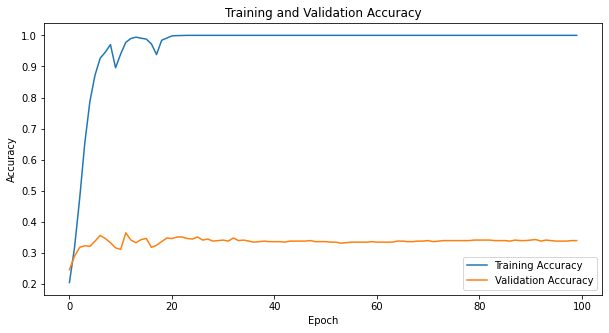

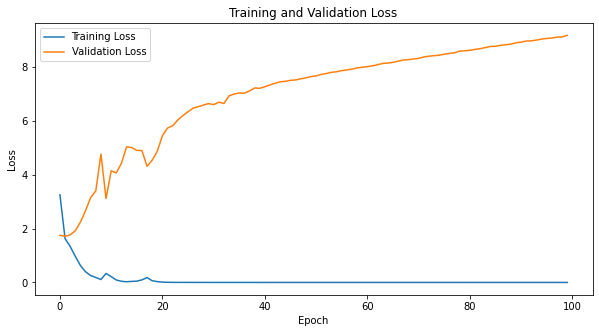

In [39]:
import matplotlib.pyplot as plt

# Initialize lists to store the training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
## Data augmentation 

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [42]:
##LeNet with data augmentation

from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation and other hyperparameters
n_folds = 5  # Number of folds for cross-validation
learning_rate = 0.001
batch_size = 32
epochs = 100

# Encode the labels
#label_encoder = LabelEncoder()
#labels_deep = label_encoder.fit_transform(labels_deep)

# Initialize lists to store the evaluation metrics for each fold
val_accuracy_per_fold_augm = []

# Perform cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels_deep)):
    print(f"Fold {fold + 1}")
    X_train_fold = images[train_index]
    y_train_fold = labels_deep[train_index]
    X_val_fold = images[val_index]
    y_val_fold = labels_deep[val_index]

    # Encode the labels
    #label_encoder = LabelEncoder()
    #y_train_fold = label_encoder.fit_transform(y_train_fold)
    #y_val_fold = label_encoder.fit_transform(y_val_fold)

    # Define the input shape and number of classes
    input_shape = (64, 64, 1)
    #input_shape = X_train_fold[0].shape
    num_classes = len(np.unique(labels_deep))

    # Create the LeNet model
    model = create_LeNet_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    history = model.fit(datagen.flow(np.expand_dims(X_train_fold, axis=-1), y_train_fold, batch_size=batch_size), epochs=epochs, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model on validation data
    y_val_pred_augm = model.predict(X_val_fold)
    y_val_pred_labels_augm = np.argmax(y_val_pred_augm, axis=1)
    y_val_true_labels_augm = y_val_fold
    #np.argmax(np.reshape(y_val_fold, (-1, 1)), axis=1)
    val_accuracy_augm = accuracy_score(y_val_true_labels_augm, y_val_pred_labels_augm)

    val_accuracy_per_fold_augm.append(val_accuracy_augm)

# Calculate and display the mean and standard deviation of the evaluation metrics across folds
print("Cross-validation results:")
print(f"Mean validation accuracy: {np.mean(val_accuracy_per_fold_augm):.4f} (+/- {np.std(val_accuracy_per_fold_augm):.4f})")

Fold 1
Epoch 1/100
75/75 [==============================] - 8s 82ms/step - loss: 10.2638 - accuracy: 0.1729 - val_loss: 1.8030 - val_accuracy: 0.2100
Epoch 2/100
75/75 [==============================] - 5s 70ms/step - loss: 1.7611 - accuracy: 0.2242 - val_loss: 1.7823 - val_accuracy: 0.2717
Epoch 3/100
75/75 [==============================] - 5s 70ms/step - loss: 1.7175 - accuracy: 0.2771 - val_loss: 1.6998 - val_accuracy: 0.3200
Epoch 4/100
75/75 [==============================] - 5s 70ms/step - loss: 1.6643 - accuracy: 0.3021 - val_loss: 1.7908 - val_accuracy: 0.3283
Epoch 5/100
75/75 [==============================] - 5s 71ms/step - loss: 1.6261 - accuracy: 0.3125 - val_loss: 1.7058 - val_accuracy: 0.3383
Epoch 6/100
75/75 [==============================] - 5s 71ms/step - loss: 1.6056 - accuracy: 0.3183 - val_loss: 1.9352 - val_accuracy: 0.3067
Epoch 7/100
75/75 [==============================] - 5s 70ms/step - loss: 1.5834 - accuracy: 0.3375 - val_loss: 1.9681 - val_accuracy: 0.313

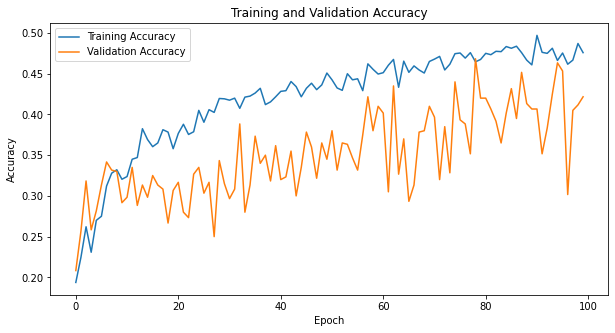

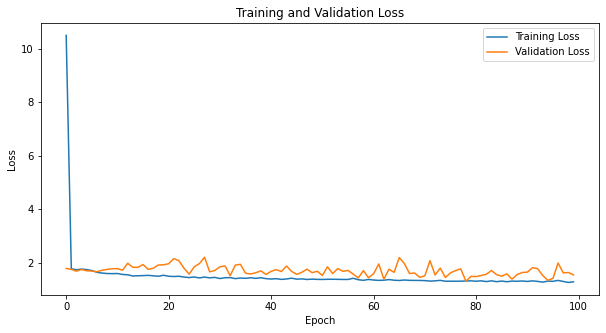

In [43]:
import matplotlib.pyplot as plt

# Initialize lists to store the training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
##Data augmentation for a Squeezenet implementation

# Define the number of folds for cross-validation and other hyperparameters
n_folds = 5  # Number of folds for cross-validation
learning_rate = 0.001
batch_size = 32
epochs = 10

# Encode the labels
label_encoder = LabelEncoder()
labels_deep = label_encoder.fit_transform(labels)

# Initialize lists to store the evaluation metrics for each fold
val_accuracy_per_fold = []

# Perform cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels_deep)):
    print(f"Fold {fold + 1}")
    X_train_fold = images[train_index] 
    y_train_fold = labels_deep[train_index]
    X_val_fold = images[val_index]
    y_val_fold = labels_deep[val_index]


    input_shape = X_train_fold.shape[1:]  # Input image shape
    num_classes = len(np.unique(labels))

    model = SqueezeNet(input_shape, num_classes)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=batch_size), epochs=epochs, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model on validation data
    y_val_pred_augm = model.predict(X_val_fold)
    y_val_pred_labels_augm = np.argmax(y_val_pred, axis=1)
    y_val_true_labels_augm = y_val_fold
    #np.argmax(np.reshape(y_val_fold, (-1, 1)), axis=1)
    
    val_accuracy_augm = accuracy_score(y_val_true_labels_augm, y_val_pred_labels_augm)

    val_accuracy_per_fold_augm.append(val_accuracy_augm)

# Calculate and display the mean and standard deviation of the evaluation metrics across folds
print("Cross-validation results:")
print(f"Mean validation accuracy: {np.mean(val_accuracy_per_fold_augm):.4f} (+/- {np.std(val_accuracy_per_fold_augm):.4f})")

NameError: name 'labels' is not defined

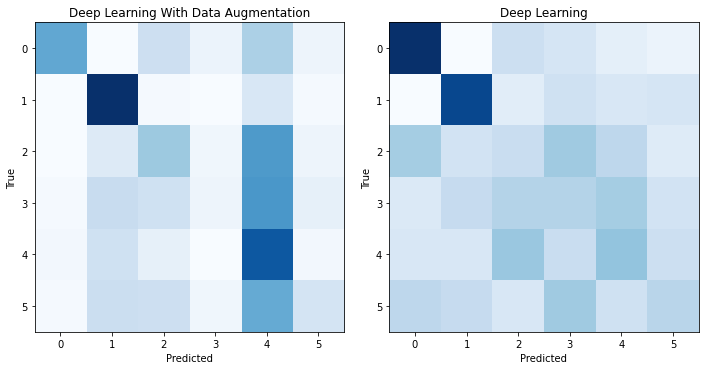

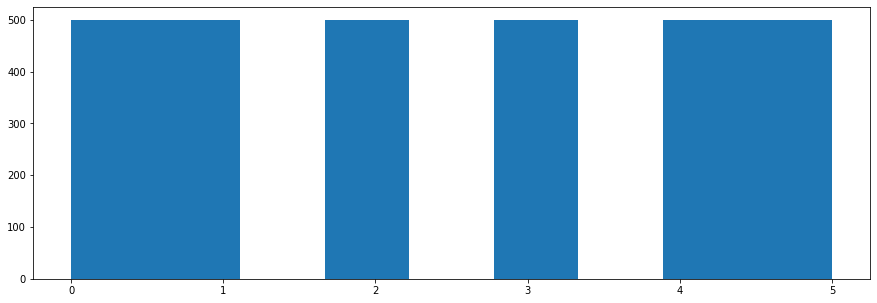

dict_keys([0, 1, 2, 3, 4, 5])


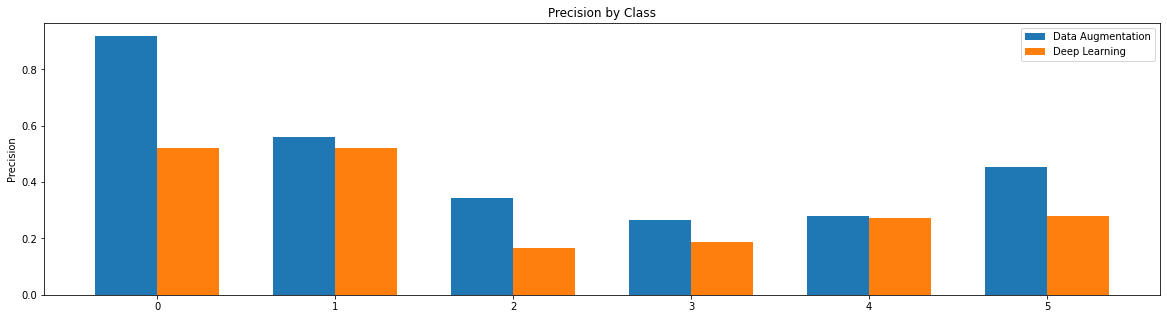

There is no significant difference between the two approaches.


In [47]:
#Compare the results with and without the data augmentation

## Detailed comparison : LeNet with and without data augmentation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from scipy.stats import ttest_rel
from collections import Counter

# Assume you have obtained the predictions and true labels for each approach
data_augm_prediction = y_val_pred_labels_augm
deep_learning_predictions = y_val_pred_labels
true_labels_deep_learning = y_val_true_labels
true_labels_data_augm = y_val_true_labels_augm

# Compute the confusion matrices
traditional_cm = confusion_matrix(y_val_true_labels_augm, y_val_pred_labels_augm)
deep_learning_cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)

# Plot the confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(traditional_cm, cmap='Blues')
axes[0].set_title('Deep Learning With Data Augmentation')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[1].imshow(deep_learning_cm, cmap='Blues')
axes[1].set_title('Deep Learning')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

#Plot Class
plt.figure(figsize=(15,5))
plt.hist(labels_deep, bins = 9)
plt.show()

# Calculate precision, recall, and F1-score for each class
traditional_metrics = precision_recall_fscore_support(true_labels_data_augm, data_augm_prediction, average=None)
deep_learning_metrics = precision_recall_fscore_support(true_labels_deep_learning, deep_learning_predictions, average=None)

# Plot class-specific metrics
classes = Counter(labels_deep)
print(classes.keys())
x = np.arange(len(classes.keys()))
width = 0.35
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(x - width/2, traditional_metrics[0], width, label='Data Augmentation')
ax.bar(x + width/2, deep_learning_metrics[0], width, label='Deep Learning')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Precision')
ax.set_title('Precision by Class')
ax.legend()
plt.show()

# Perform statistical test
_, p_value = ttest_rel(traditional_metrics[0], deep_learning_metrics[0])
if p_value < 0.05:
    print("There is a significant difference between the two approaches.")
else:
    print("There is no significant difference between the two approaches.")
